## Deep Learning Study
#### Week 4: CNN & Transfer Learning
![image](https://user-images.githubusercontent.com/44901828/228611874-e925c922-5ac3-4b30-a1cc-960adc09a166.png)
- Pytorch에서 제공하는 nn.Module 클래스를 활용하여 간단한 딥 러닝 모델을 설계하고, [Fashion MNIST data](https://github.com/zalandoresearch/fashion-mnist)를 분류할 수 있도록 학습시켜 봅시다.
- Fashion MNIST 데이터셋은 기존 MNIST 데이터셋의 단점(분류 난이도가 너무 쉽고, 너무 많이 사용되어 식상하다는 등...)을 개선하기 위해 제안된 데이터셋으로, 다양한 카테고리의 패션 아이템 이미지로 구성되어 있습니다.
- Fashion MNIST 분류 문제를 잘 푸는 모델은 input으로 다양한 종류의 패션 아이템의 이미지 데이터를 받아 output으로 해당 아이템이 속한 카테고리를 정확하게 예측하는 모델이라고 할 수 있습니다.

In [3]:
import random
import numpy as np
import torchvision
import torch

# 재현을 위해 seed 고정
random.seed(42)
np.random.seed(42)

# GPU 사용 여부
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# MNIST
train_dataset = torchvision.datasets.FashionMNIST(root="./data", transform=torchvision.transforms.ToTensor(), train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", transform=torchvision.transforms.ToTensor(), train=False, download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11913111.38it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212634.01it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3752756.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5840486.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



- 불러온 Fashion MNIST 데이터셋이 어떤 형태로 구성되어 있는지 확인해 보겠습니다.
- 각각의 데이터는 MNIST와 마찬가지로 28x28 크기의 이미지와 숫자 라벨로 구성되어 있네요.
- 참고로 이 데이터셋을 사람이 직접 설문조사 형태로 참여해서 분류했을 때 정확도는 약 83.5% 였습니다.
- 각 라벨의 값과 실제 카테고리 설명은 아래와 같습니다.

|Label|Description|
|:--|:--|
|0|T-shirt/top|
|1|Trouser|
|2|Pullover|
|3|Dress|
|4|Coat|
|5|Sandal|
|6|Shirt|
|7|Sneaker|
|8|Bag|
|9|Ankle boot|

In [4]:
from torchvision.transforms.functional import to_pil_image

ids_to_labels = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}

print("Total data:", len(train_dataset))
for i in range(5):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    print(f"\n[Image] {image.shape}")
    to_pil_image(image).show()
    print(f"[Label] {label} {ids_to_labels[label]}")

Total data: 60000

[Image] torch.Size([1, 28, 28])


[Label] 9 Ankle boot

[Image] torch.Size([1, 28, 28])


[Label] 0 T-shirt/top

[Image] torch.Size([1, 28, 28])


[Label] 0 T-shirt/top

[Image] torch.Size([1, 28, 28])


[Label] 3 Dress

[Image] torch.Size([1, 28, 28])


[Label] 0 T-shirt/top


![image](https://user-images.githubusercontent.com/44901828/229989911-d544fedb-9512-4411-91ee-1a8f94daf029.png)
- 이번에는 Fashion MNIST 분류를 학습할 모델로 CNN을 사용해 보겠습니다.
- 입력되는 이미지에 대해 convolution과 pooling 연산을 수행하는 간단한 네트워크를 nn.Module 클래스를 사용하여 구성합니다.

In [5]:
from torch import nn

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding="valid"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding="valid"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=4*4*64, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
)

model.to('cuda')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

![image](https://user-images.githubusercontent.com/44901828/228437940-59595fa6-8046-45f0-9b2f-7b35df470702.png)
- 분류 문제에 일반적으로 사용되는 Cross Entropy Loss를 불러와 사용하겠습니다.
- 학습 과정에서 일정 단위의 데이터를 쉽게 불러와 사용할 수 있게 해주는 DataLoader를 사용하도록 하겠습니다.

In [6]:
loss_function = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

- 위에서 준비한 dataloader, 모델, loss를 이용하여 학습을 진행합니다.
- Forward/backward pass를 여러번 반복하며 loss가 작아지도록 gradient descent와 back propagation을 수행하는 과정은 torch를 이용하여 간단하게 수행 가능합니다.
- Optimizer는 [Adam](https://gaussian37.github.io/dl-dlai-Adam/)을 사용했습니다.
- 전체 데이터에 대해 학습이 진행된 횟수를 epoch라고 합니다. 1 epoch가 지날 때 마다 train data를 잘 분류하는지 확인하기 위해 test 함수를 호출해 줍니다.

In [51]:
from tqdm import tqdm

def train(dataloader):
  num_epochs = 10
  loss_per_step = []

  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

  for epoch in range(num_epochs):
    for i, (images, labels) in tqdm(enumerate(dataloader), desc=f"Training epoch {epoch}"):
        # Forward pass
        outputs = model(images.to(device))

        # Loss 계산 및 저장
        loss = loss_function(outputs, labels.to('cuda'))
        loss_per_step.append(loss.detach().cpu().item())
        
        # Backward pass    
        # 계산된 gradient를 활용하여 파라미터 업데이트
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    acc = test(dataloader)    
    print(f"epoch {epoch+1}/{num_epochs}, train loss = {loss.item():.4f}, train accuracy: {acc:.2f}%")
      
  return loss_per_step

def test(dataloader):
  with torch.no_grad():
    n_correct = 0
    n_samples =0
    for images, labels in tqdm(dataloader, desc="Evaluation in progress"):
        outputs = model(images.to(device)).detach().cpu()
        # value, index
        predictions = torch.argmax(outputs,dim=1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
        
    acc = 100 * n_correct / n_samples
    return acc

- 학습이 진행되며 train loss는 감소하고, train accuracy는 증가하는 것을 볼 수 있습니다.
- 하지만 train data에 대해서 평가한 것만으로는 모델의 성능을 객관적으로 평가할 수 없습니다. 학습에 사용되지 않은 test 데이터를 사용해서 모델의 분류 성능을 평가해보도록 하겠습니다.

epoch 1/10, train loss = 0.6097, train accuracy: 76.45%
epoch 2/10, train loss = 0.5003, train accuracy: 81.96%
epoch 3/10, train loss = 0.4230, train accuracy: 84.64%
epoch 4/10, train loss = 0.4164, train accuracy: 86.24%
epoch 5/10, train loss = 0.4448, train accuracy: 86.10%
epoch 6/10, train loss = 0.4478, train accuracy: 87.69%
epoch 7/10, train loss = 0.3275, train accuracy: 88.10%
epoch 8/10, train loss = 0.3333, train accuracy: 88.18%
epoch 9/10, train loss = 0.3170, train accuracy: 89.38%
epoch 10/10, train loss = 0.3059, train accuracy: 89.79%


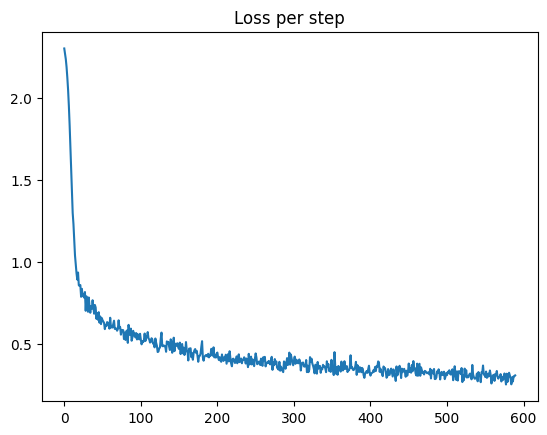

In [8]:
from matplotlib import pyplot as plt

loss_per_step = train(train_loader)

plt.plot(loss_per_step)
plt.title("Loss per step")
plt.show()

- 지난 과제에서 사용했던 fully connected layer보다 조금 더 나은 분류 성능을 보여주네요!
- 하이퍼파라미터를 잘 변경하면 더 나은 성능을 보여줄 수도 있지만 이 네트워크에도 한계가 존재하는것 같네요.

In [9]:
train_acc = test(train_loader)
test_acc = test(test_loader)

print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

Train accuracy: 89.79%
Test accuracy: 88.52%


- 이번에는 이미 수많은 이미지에 대해 학습된 MobileNet의 파라미터를 불러와 Fashion MNIST를 분류할 수 있는 모델로 학습시켜 보겠습니다.
- PyTorch의 컴퓨터 비전 라이브러리인 torchvision을 사용하면 mobilenet을 비롯한 다양한 사전 학습된 네트워크를 쉽게 불러와 사용할 수 있습니다.

In [63]:
from torchvision.models.mobilenet import mobilenet_v2

# weights 옵션을 통해 빈 모델만 불러오거나
# 사전학습된 파라미터를 불러오는 것 중 선택 가능
model = mobilenet_v2(weights=True)

# Fashion MNIST의 class 개수만큼 출력하도록 output layer 변형
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- MobileNet은 컬러(RGB) 이미지를 학습하도록 한 모델이기 때문에, 흑백 이미지인 MNIST를 바로 사용할 수 없습니다.
- MobileNet의 입력 차원과 일치시키기 위한 작업을 수행하는 collate function을 정의하여 Dataloader를 새로 정의합니다.
- Collate function은 Dataloader가 모델에 데이터를 전달하기 직전 데이터에 대해 호출되는 함수입니다.

In [ ]:
# 1채널(흑백) 데이터를 3채널(RGB) 데이터와 같은
# 형태로 복제해주는 collate function
def channel_repeater(data):
  images = []
  labels = []
  for i, (image, label) in enumerate(data):
    images.append(image.repeat((1, 3, 1, 1)))
    labels.append(label)
  return (torch.cat(images), torch.tensor(labels))

# 새로 정의된 collator를 활용하여 dataloader 재정의
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True, collate_fn=channel_repeater)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False, collate_fn=channel_repeater)

- 이제 MobileNet으로 Fashion MNIST를 분류할 준비가 다 되었습니다!
- 모델의 구조는 바뀌었지만, 학습 방식이 달라진 것은 없기 때문에 기존에 사용했던 학습 코드를 그대로 활용할 수 있습니다.

epoch 1/10, train loss = 0.3324, train accuracy: 90.09%
epoch 2/10, train loss = 0.2662, train accuracy: 92.76%
epoch 3/10, train loss = 0.1658, train accuracy: 94.40%
epoch 4/10, train loss = 0.1862, train accuracy: 94.24%
epoch 5/10, train loss = 0.1389, train accuracy: 95.09%
epoch 6/10, train loss = 0.1355, train accuracy: 96.19%
epoch 7/10, train loss = 0.1427, train accuracy: 96.41%
epoch 8/10, train loss = 0.1394, train accuracy: 96.97%
epoch 9/10, train loss = 0.1276, train accuracy: 96.97%
epoch 10/10, train loss = 0.0836, train accuracy: 97.69%


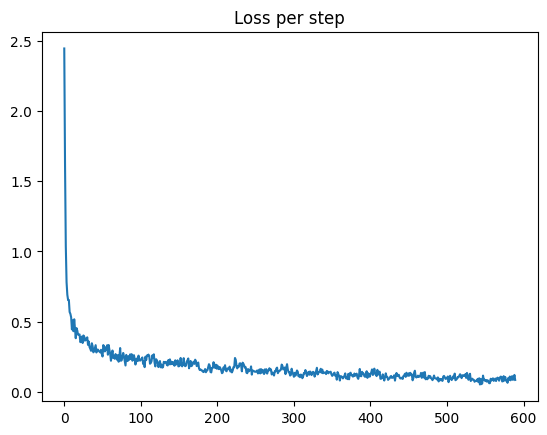

In [64]:
loss_per_step = train(train_loader)

plt.plot(loss_per_step)
plt.title("Loss per step")
plt.show()

- 학습 결과 fully connected network나 기본적인 CNN 네트워크에 비해 더 뛰어난 분류 성능을 보여줍니다!
- 같은 분류 문제를 해결할 때에도, 어떤 모델을 사용하느냐에 따라 성능이 크게 차이나는 것을 알 수 있습니다.

In [65]:
train_acc = test(train_loader)
test_acc = test(test_loader)

print(f"Train accuracy: {train_acc:.2f}%")
print(f"Test accuracy: {test_acc:.2f}%")

Train accuracy: 97.67%
Test accuracy: 92.45%
